In [1]:
from importlib import reload
import os
import pandas as pd
from io import StringIO
import itertools
import ipdb
import datetime
from collections import Counter

import h5py
import json
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import joblib
print(tf.__version__)

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM

from keras.callbacks import EarlyStopping
from tensorflow.compat.v1.losses import sparse_softmax_cross_entropy

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import mytf.s3utils as msu
import mytf.utils as mu
import mytf.validation as mv
import mytf.plot as mp

1.14.0


Using TensorFlow backend.


In [2]:
tf.enable_eager_execution()


In [4]:
mu.build_many_scalers_from_h5??

In [14]:


# Use both train and test to make the scaler this time...
datadir = 'data/2019-12-21T215926Z'
trainloc = f'{datadir}/train.h5'
scaler, params_vec = mu.build_many_scalers_from_h5(
                        trainloc, 
                        datasets=[x for x in mu.h5_keys(trainloc) 
                               if '_X' in x]
)



And per [earlier](https://github.com/namoopsoo/aviation-pilot-physiology-hmm/blob/master/notes/2019-12-21--update.md#multi-scaler-instead)  , I can look at the min/max the scaler was building up...

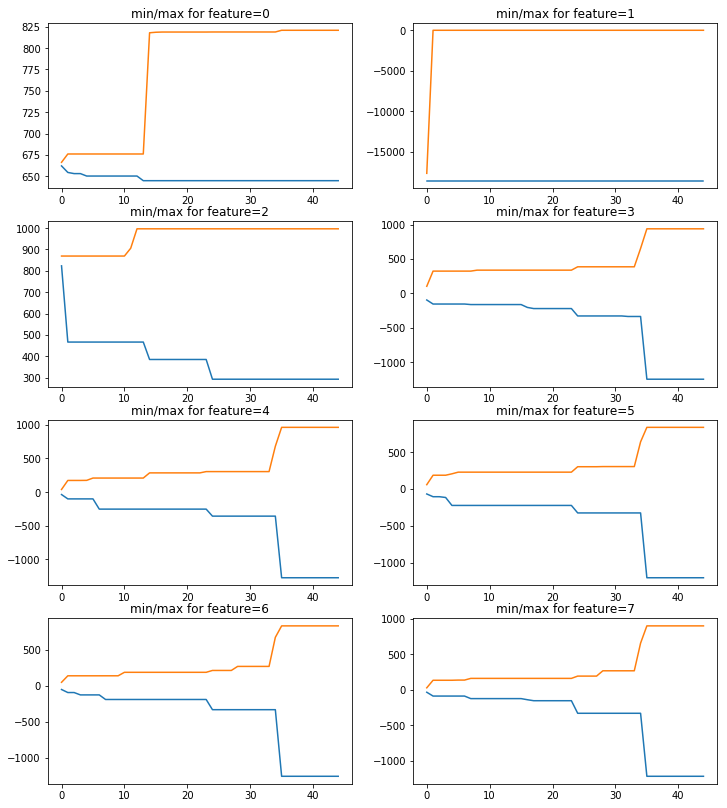

In [15]:
# Ok for the below, looks like this other scaling 
# is working the same way cool..
themin, themax = 0, 1

fig = plt.figure(figsize=(12, 14))
#for i in range(8):


for col in range(8):
    #params_vec = outvec[i][1]
    ax = fig.add_subplot(int('42' + str(col+1)))
    #ax.plot(params_vec)
    ax.set(title=(f'min/max for feature={col}'))

    ax.plot(
        [params_vec[i][themin][col] for i in range(len(params_vec))]
    
    )
    ax.plot(
    [params_vec[i][themax][col] for i in range(len(params_vec))]
    )

Ok, and now just keep building on the test set too...
Just to see what happens!!

In [16]:
[scaler.data_min_, scaler.data_max_] #, params_vec

[array([   644.765991, -18585.69922 ,    292.071991,  -1246.959961,
         -1271.77002 ,  -1206.800049,  -1261.699951,  -1220.51001 ]),
 array([820.900024,   0.      , 996.85199 , 939.40802 , 960.846008,
        839.700989, 836.572021, 900.937012])]

In [17]:
testloc = f'{datadir}/test.h5'
scaler, params_vec_2 = mu.build_many_scalers_from_h5(
                        testloc, 
                        datasets=[x for x in mu.h5_keys(testloc) 
                               if '_X' in x],
                        scaler=scaler
)



In [19]:
print('before:', [([   644.765991, -18585.69922 ,    292.071991,  -1246.959961,
         -1271.77002 ,  -1206.800049,  -1261.699951,  -1220.51001 ]),
 ([820.900024,   0.      , 996.85199 , 939.40802 , 960.846008,
        839.700989, 836.572021, 900.937012])])
print('now...', [scaler.data_min_, scaler.data_max_])


before: [[644.765991, -18585.69922, 292.071991, -1246.959961, -1271.77002, -1206.800049, -1261.699951, -1220.51001], [820.900024, 0.0, 996.85199, 939.40802, 960.846008, 839.700989, 836.572021, 900.937012]]
now... [array([   644.765991, -18585.69922 ,      0.      ,  -1246.959961,
        -1271.77002 ,  -1206.800049,  -1261.699951,  -1220.51001 ]), array([  828.35199 , 11498.299805,  1999.859985,   939.40802 ,
         960.846008,   839.700989,   836.572021,   900.937012])]


Hmm ok some has changed here.

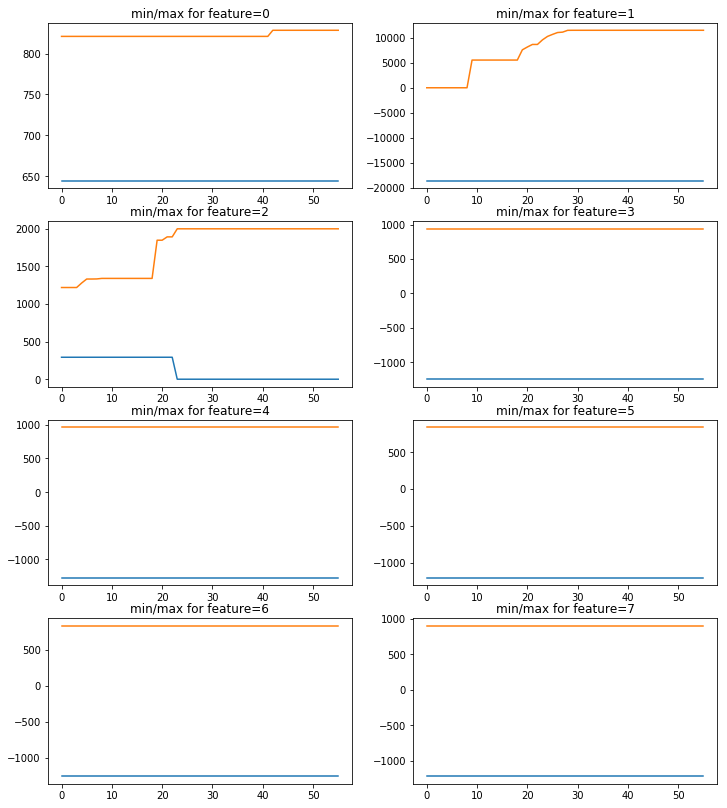

In [26]:
# Ok for the below, looks like this other scaling 
# is working the same way cool..
themin, themax = 0, 1

fig = plt.figure(figsize=(12, 14))
#for i in range(8):


for col in range(8):
    #params_vec = outvec[i][1]
    ax = fig.add_subplot(int('42' + str(col+1)))
    #ax.plot(params_vec)
    ax.set(title=(f'min/max for feature={col}'))

    ax.plot(
        [params_vec_2[i][themin][col] for i in range(len(params_vec_2))]
    
    )
    ax.plot(
    [params_vec_2[i][themax][col] for i in range(len(params_vec_2))]
    )

#### Okay now apply....

In [27]:
# Working dir... for new model
save_dir = 'history'
ts = mu.quickts(); print('starting,', ts)

workdir = f'{save_dir}/{ts}'
os.mkdir(workdir)
print(f'Made new workdir, {workdir}')

starting, 2020-02-02T044441Z
Made new workdir, history/2020-02-02T044441Z


In [28]:
trainloc, testloc

('data/2019-12-21T215926Z/train.h5', 'data/2019-12-21T215926Z/test.h5')

In [42]:
reload(mu)

<module 'mytf.utils' from '/home/ec2-user/SageMaker/aviation-pilot-physiology-hmm/mytf/utils.py'>

In [43]:
# new work dir for new data..
mu.apply_scalers(trainloc, 
               datasets=[x for x in mu.h5_keys(trainloc) 
                           if '_X' in x],
               scaler=scaler,
               outloc=f'{workdir}/train_scaled.h5'

                  )
mu.transfer(source_location=trainloc, 
            source_datasets=[x for x in mu.h5_keys(trainloc) 
                               if '_Y' in x], 
            save_location=f'{workdir}/train_scaled.h5')

#### Ok now make that balanced data next

In [45]:
# ok... make train set...
# max 7625
train_scaled_loc = f'{workdir}/train_scaled.h5'
train_balanced_loc = f'{workdir}/train_balanced.h5'
print(os.listdir(workdir))

datasets = list(zip([x for x in mu.h5_keys(train_scaled_loc) 
                               if '_X' in x],
                    [x for x in mu.h5_keys(train_scaled_loc) 
                               if '_Y' in x]))

for k in [0, 1, 2, 3]:
    mu.transfer_data(
        source_location=train_scaled_loc,
        source_datasets=datasets,
        save_location=train_balanced_loc,
        label=k,
        howmany=7625)

['train_scaled.h5']
ok breaking
Saved with  Counter({0: 10230})
ok breaking
Saved with  Counter({1: 7625})
ok breaking
Saved with  Counter({2: 8286})
ok breaking
Saved with  Counter({3: 8839})


#### Save the scaler for later.

In [46]:

joblib.dump(scaler, f'{workdir}/scalers.joblib')

['history/2020-02-02T044441Z/scalers.joblib']

In [47]:
os.listdir(workdir)

['train_balanced.h5', 'scalers.joblib', 'train_scaled.h5']

In [48]:
mu.count_data_in_location(loc=train_scaled_loc,
                          datasets=[x for x in mu.h5_keys(train_scaled_loc) 
                               if '_Y' in x])

{0: 234038, 1: 7625, 2: 179699, 3: 23090}

In [53]:
mu.h5_keys(train_scaled_loc)

['dataset_0_X_scaled',
 'dataset_0_Y',
 'dataset_10_X_scaled',
 'dataset_10_Y',
 'dataset_11_X_scaled',
 'dataset_11_Y',
 'dataset_12_X_scaled',
 'dataset_12_Y',
 'dataset_13_X_scaled',
 'dataset_13_Y',
 'dataset_14_X_scaled',
 'dataset_14_Y',
 'dataset_15_X_scaled',
 'dataset_15_Y',
 'dataset_16_X_scaled',
 'dataset_16_Y',
 'dataset_17_X_scaled',
 'dataset_17_Y',
 'dataset_18_X_scaled',
 'dataset_18_Y',
 'dataset_19_X_scaled',
 'dataset_19_Y',
 'dataset_1_X_scaled',
 'dataset_1_Y',
 'dataset_20_X_scaled',
 'dataset_20_Y',
 'dataset_21_X_scaled',
 'dataset_21_Y',
 'dataset_22_X_scaled',
 'dataset_22_Y',
 'dataset_23_X_scaled',
 'dataset_23_Y',
 'dataset_24_X_scaled',
 'dataset_24_Y',
 'dataset_25_X_scaled',
 'dataset_25_Y',
 'dataset_26_X_scaled',
 'dataset_26_Y',
 'dataset_27_X_scaled',
 'dataset_27_Y',
 'dataset_28_X_scaled',
 'dataset_28_Y',
 'dataset_29_X_scaled',
 'dataset_29_Y',
 'dataset_2_X_scaled',
 'dataset_2_Y',
 'dataset_30_X_scaled',
 'dataset_30_Y',
 'dataset_31_X_scaled'

In [51]:
mu.h5_keys(train_balanced_loc) 

['X_0',
 'X_1',
 'X_2',
 'X_3',
 'Ylabels_0',
 'Ylabels_1',
 'Ylabels_2',
 'Ylabels_3']

In [57]:
X, Y = mu.read_h5_two(train_balanced_loc, 'X_0', 'Ylabels_0')

In [59]:
Y[:5]

array([0., 0., 0., 0., 0.])

#### Shuffle also
As per [earlier](https://github.com/namoopsoo/aviation-pilot-physiology-hmm/blob/master/notes/2019-12-25.md#do-a-shuffle)

In [60]:
# ok save the shuffled dataset too for repeatability...
# Grab and randomize since it's not huge...
vecs = [mu.read_h5_two(
                source_location=train_balanced_loc, 
                Xdataset=f'X_{i}',
                Ydataset=f'Ylabels_{i}')
                 for i in [0, 1, 2, 3]]

X_train = np.concatenate([x[0] for x in vecs])
Ylabels_train = np.concatenate([x[1] for x in vecs])

# Shuffle...
size = X_train.shape[0]
print(size)
indices = np.random.choice(range(size), size=size, replace=False)
X_train_shfl = X_train[indices]
Ylabels_train_shfl = Ylabels_train[indices].astype('int64')

X = X_train_shfl
Ylabels = Ylabels_train_shfl

# SAVE ...
mu.save_that(save_location=f'{workdir}/train_scaled_balanced_shuffled.h5', 
             name='X', X=X)

34980


In [69]:
mu.save_that(save_location=f'{workdir}/train_scaled_balanced_shuffled.h5', 
             name='Ylabels', X=Ylabels)

RuntimeError: Unable to create link (name already exists)

In [70]:
print(mu.h5_keys('history/2019-12-22T174803Z/train_scaled_balanced_shuffled.h5'))

print(mu.h5_keys(
f'{workdir}/train_scaled_balanced_shuffled.h5'))


['X', 'Ylabels']
['X', 'Ylabels']


#### And train.

In [71]:
os.listdir(workdir)

['train_balanced.h5',
 'scalers.joblib',
 'train_scaled_balanced_shuffled.h5',
 'train_scaled.h5']

In [73]:
lstm_params = [{
    'units': 64,
    'dropout': 0.5,
    'recurrent_dropout': 0.5,
    'batch_input_shape': (None, 64, 8),
    'kernel_initializer': tf.initializers.glorot_normal() # GlorotNormal()
                           #tf.initializers.he_normal()
    },

]

optimizer_params = {
    'learning_rate': 0.001,  
    'beta1': 0.9, 
    'beta2': 0.999, 
    'epsilon': 1e-08
}

def bake_model(lstm_params):

    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(**lstm_params[0]),
        # 4 because 'A', 'B', 'C', 'D'.
        tf.keras.layers.Dense(4)])
    return model

In [74]:
BATCH_SIZE = 32
EPOCHS = 1
#
print('workdir', workdir)
train_shuff_loc = f'{workdir}/train_scaled_balanced_shuffled.h5'



X, Ylabels = mu.read_h5_two(
                source_location=train_shuff_loc, 
                Xdataset=f'X',
                Ydataset=f'Ylabels')
size = X.shape[0]

# save base unfitted model.
model = bake_model(lstm_params)
mu.save_model(model=model, 
              loc=f'{workdir}/00000__unfitted_model.h5')

workdir history/2020-02-02T044441Z


In [75]:
%%time
modelloc = f'{workdir}/00000__unfitted_model.h5'
print(f'Start train with {modelloc}')
model = mu.load_model(modelloc)

class_weights = {0: 1., 1: 0., 2: 0., 3: 0.}
dataset_batches = mu.build_dataset_weighty_v3(
        {'x_train': X,
         'ylabels_train': Ylabels.astype('int64')},
        list(range(size)), 
        class_weights,
        batch_size=BATCH_SIZE)
    
ipdb.runcall(mu.do_train,
        model,
        dataset_batches,
        k=size,
        epochs=EPOCHS,
        optimizer_params=optimizer_params,
        saveloc=workdir)

Start train with history/2020-02-02T044441Z/00000__unfitted_model.h5
> /home/ec2-user/SageMaker/aviation-pilot-physiology-hmm/mytf/utils.py(254)do_train()
    253 def do_train(model, dataset_batches, k, epochs, optimizer_params, saveloc):
--> 254     optimizer = AdamOptimizer(**optimizer_params)
    255 

ipdb> c


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


InvalidArgumentError: slice index 4 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/

oh yea and scale test set then

In [76]:
testloc

'data/2019-12-21T215926Z/test.h5'

In [81]:
workdir

'history/2020-02-02T044441Z'

Somehow i ran outof disk space..

```
(tensorflow_p36) [ec2-user@ip-172-16-173-88 aviation-pilot-physiology-hmm]$ df -h
Filesystem      Size  Used Avail Use% Mounted on
devtmpfs        1.9G   64K  1.9G   1% /dev
tmpfs           1.9G  8.0K  1.9G   1% /dev/shm
/dev/nvme0n1p1   99G   67G   32G  69% /
/dev/nvme1n1     20G   19G     0 100% /home/ec2-user/SageMaker

(tensorflow_p36) [ec2-user@ip-172-16-173-88 aviation-pilot-physiology-hmm]$ mkdir /home/ec2-user/blahspace/data
(tensorflow_p36) [ec2-user@ip-172-16-173-88 aviation-pilot-physiology-hmm]$ ls -lah /home/ec2-user/SageMaker/aviation-pilot-physiology-hmm/data
total 4.7G
drwxrwxr-x 3 ec2-user ec2-user 4.0K Dec 21 21:59 .
drwxrwxr-x 8 ec2-user ec2-user 4.0K Feb  2 06:43 ..
-rw-rw-r-- 1 ec2-user ec2-user 262M Dec 13 17:48 2019-12-07-test-balanced.h5
-rw-rw-r-- 1 ec2-user ec2-user 134M Dec 14 18:29 2019-12-07-train-balanced.h5
drwxrwxr-x 2 ec2-user ec2-user 4.0K Dec 21 22:00 2019-12-21T215926Z
-rw-rw-r-- 1 ec2-user ec2-user  94M Nov  2 13:30 crew_1-train.pkl
-rw-rw-r-- 1 ec2-user ec2-user 116M Nov  2 13:40 crew_2-train.pkl
-rw-rw-r-- 1 ec2-user ec2-user 116M Nov  3 23:03 crew_3-train.pkl
-rw-rw-r-- 1 ec2-user ec2-user 117M Nov  3 23:03 crew_4-train.pkl
-rw-rw-r-- 1 ec2-user ec2-user 2.2G Dec  7 23:56 test.h5
-rw-rw-r-- 1 ec2-user ec2-user 1.8G Dec  8 20:07 train.h5

(tensorflow_p36) [ec2-user@ip-172-16-173-88 aviation-pilot-physiology-hmm]$ mv data/*h5
2019-12-07-test-balanced.h5   test.h5
2019-12-07-train-balanced.h5  train.h5
(tensorflow_p36) [ec2-user@ip-172-16-173-88 aviation-pilot-physiology-hmm]$ mv data/*h5 /home/ec2-user/blahspace/data

(tensorflow_p36) [ec2-user@ip-172-16-173-88 aviation-pilot-physiology-hmm]$ df -h
Filesystem      Size  Used Avail Use% Mounted on
devtmpfs        1.9G   64K  1.9G   1% /dev
tmpfs           1.9G  8.0K  1.9G   1% /dev/shm
/dev/nvme0n1p1   99G   72G   28G  73% /
/dev/nvme1n1     20G   15G  4.3G  78% /home/ec2-user/SageMaker

```

In [83]:
# new work dir for new data..
mu.apply_scalers(testloc, 
               datasets=[x for x in mu.h5_keys(testloc) 
                           if '_X' in x],
               scaler=scaler,
               outloc=f'{workdir}/test_scaled.h5'

                  )
mu.transfer(source_location=testloc, 
            source_datasets=[x for x in mu.h5_keys(testloc) 
                               if '_Y' in x], 
            save_location=f'{workdir}/test_scaled.h5')

And balance

In [89]:
test_scaled_loc = f'{workdir}/test_scaled.h5'
mu.count_data_in_location(loc=test_scaled_loc,
                          datasets=[x for x in mu.h5_keys(test_scaled_loc) 
                               if '_Y' in x])

{0: 323937, 1: 15371, 2: 182734, 3: 26922}

In [90]:
# ok... make train set...
# max 15371
test_scaled_loc = f'{workdir}/test_scaled.h5'
test_balanced_loc = f'{workdir}/test_balanced.h5'

datasets = list(zip([x for x in mu.h5_keys(test_scaled_loc) 
                               if '_X' in x],
                    [x for x in mu.h5_keys(test_scaled_loc) 
                               if '_Y' in x]))

for k in [0, 1, 2, 3]:
    mu.transfer_data(
        source_location=test_scaled_loc,
        source_datasets=datasets,
        save_location=test_balanced_loc,
        label=k,
        howmany=15371)

ok breaking
Saved with  Counter({0: 16263})
ok breaking
Saved with  Counter({1: 15371})
ok breaking
Saved with  Counter({2: 19755})
ok breaking
Saved with  Counter({3: 15542})


#### Okay try validation

In [91]:
epoch = 0
print(len(list(np.arange(200, 1100, 200))))
for batch in tqdm(list(np.arange(200, 1100, 200))):
    step = batch
    prefix = (f'{workdir}/epoch_{str(epoch).zfill(3)}'
                           f'_batch_{str(batch).zfill(5)}')

    modelname = f'{prefix}_model.h5'
    print(modelname, os.path.exists(modelname))

100%|██████████| 5/5 [00:00<00:00, 2903.44it/s]

5
history/2020-02-02T044441Z/epoch_000_batch_00200_model.h5 True
history/2020-02-02T044441Z/epoch_000_batch_00400_model.h5 True
history/2020-02-02T044441Z/epoch_000_batch_00600_model.h5 True
history/2020-02-02T044441Z/epoch_000_batch_00800_model.h5 True
history/2020-02-02T044441Z/epoch_000_batch_01000_model.h5 True


  0%|          | 0/5 [00:00<?, ?it/s]

starting validation 2020-02-02T071946Z
test_loc history/2020-02-02T044441Z/test_balanced.h5
history/2020-02-02T044441Z/epoch_000_batch_00200_model.h5 True


 20%|██        | 1/5 [05:40<22:40, 340.06s/it]

history/2020-02-02T044441Z/epoch_000_batch_00400_model.h5 True


 40%|████      | 2/5 [11:21<17:01, 340.55s/it]

history/2020-02-02T044441Z/epoch_000_batch_00600_model.h5 True


 60%|██████    | 3/5 [16:59<11:19, 339.85s/it]

history/2020-02-02T044441Z/epoch_000_batch_00800_model.h5 True


 80%|████████  | 4/5 [22:38<05:39, 339.31s/it]

history/2020-02-02T044441Z/epoch_000_batch_01000_model.h5 True


100%|██████████| 5/5 [28:14<00:00, 338.94s/it]

done validation 2020-02-02T074800Z


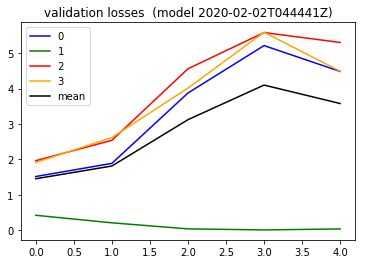

In [92]:
print('starting validation', mu.quickts())
batch_losses_vec = []
test_loc = test_balanced_loc
print('test_loc', test_loc)
epoch = 0
for batch in tqdm(list(np.arange(200, 1100, 200))):
    step = batch
    prefix = (f'{workdir}/epoch_{str(epoch).zfill(3)}'
                           f'_batch_{str(batch).zfill(5)}')

    modelname = f'{prefix}_model.h5'
    print(modelname, os.path.exists(modelname))

    steploss = mv.perf_wrapper(modelname,
                               dataloc=test_loc,
                               eager=True,
                              batch_size=32)
    batch_losses_vec.append([float(x) for x in steploss])
    mu.to_json_local({'batch_losses_vec': batch_losses_vec,
                  'step': int(step)
              }, 
              f'{prefix}_validation_losses.json')
    
print('done validation', mu.quickts())
#####
lossesarr = np.array(batch_losses_vec)
meanlossesarr = np.mean(lossesarr, axis=1)

batch_losses_vec[:5]
#batch_losses_vec = []
#for step in np.arange(0, 1068, 10):

plt.plot([x[0] for x in batch_losses_vec], color='blue', label='0')
plt.plot([x[1] for x in batch_losses_vec], color='green', label='1')
plt.plot([x[2] for x in batch_losses_vec], color='red', label='2')
plt.plot([x[3] for x in batch_losses_vec], color='orange', label='3')
plt.plot(meanlossesarr, color='black', label='mean')
plt.title(f'validation losses  (model {ts})')
plt.legend()     
        